# Wire validation

## Problem 1 : SOLVED

## Problem 2: SOLVED

When the physical length of the wire is increased ($L_{phy}\to 10,000L_w$), the results are perfectly consistent with the BB wire and the multipolar wire.

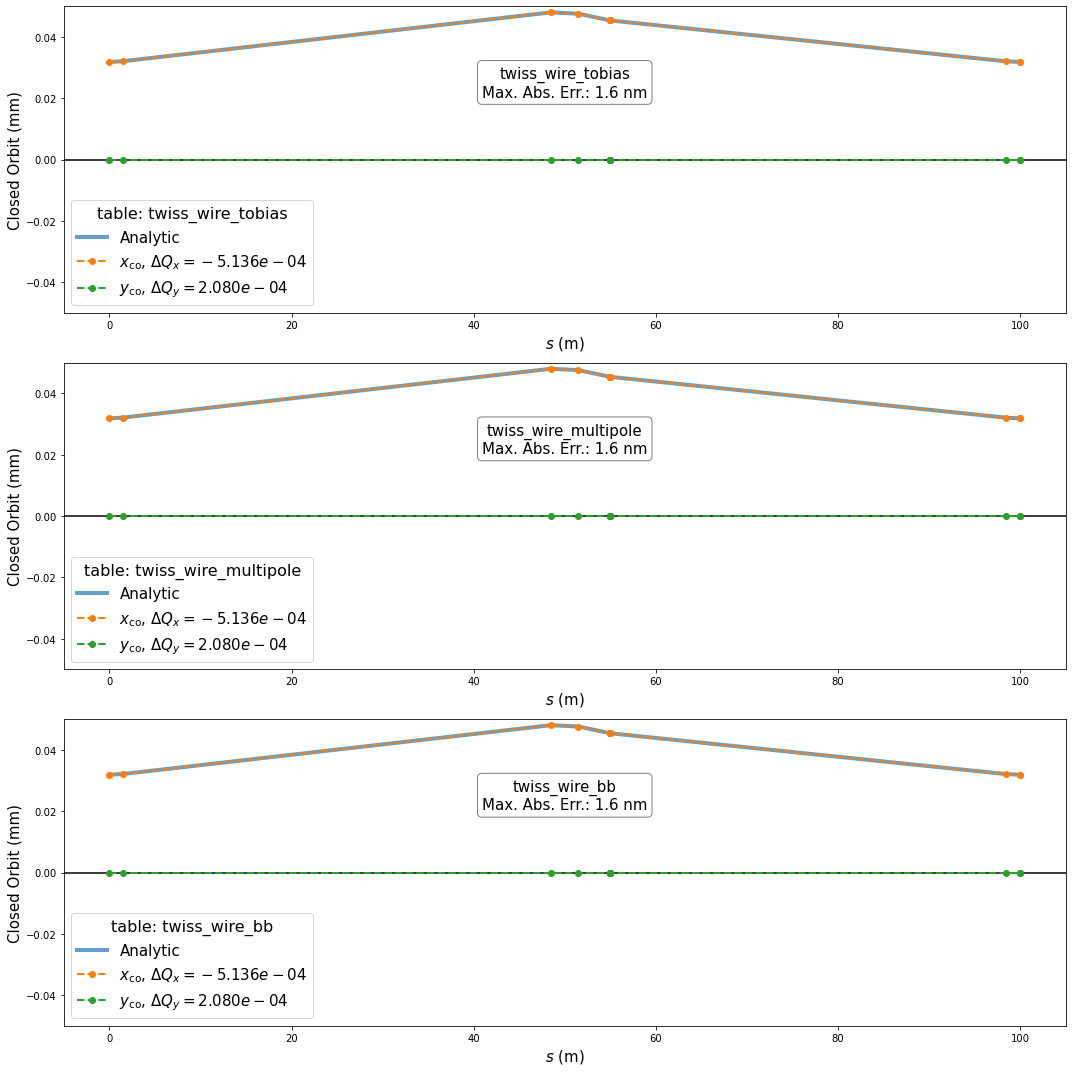

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from cpymad.madx import Madx


# Running mad file
mad = Madx()
mad.option(echo = True, warn = True)
mad.call(file='problem2.mad')

# Extracting twiss tables
twiss_ref = mad.table['twiss_ref'].dframe()
tableNames = list(mad.table.keys())[2:]


def getKick(mad,xObs,yObs):
    q =  1 # when p0c given in eV
    p0,L,I = mad.globals['P0'],mad.globals['L_w'],np.max([mad.globals['I_w1'],mad.globals['I_w2'],mad.globals['I_w3']])
    x,y = mad.globals['r_w']*np.cos(mad.globals['theta_w']),mad.globals['r_w']*np.sin(mad.globals['theta_w'])
    
    rVec = np.sqrt((x-xObs)**2 + (y-yObs)**2)
    amplitude = q*L*(mad.globals['U0']*I/(2*np.pi*rVec))/(p0)

    Px = amplitude*(x-xObs)/rVec
    Py = amplitude*(y-yObs)/rVec

    return Px,Py

fig,axes = plt.subplots(len(tableNames),1,figsize=(15,15))
for table,ax in zip(tableNames,axes):
    twiss = mad.table[table].dframe()
    
    DQx = twiss.iloc[-1]['mux'] - twiss_ref.iloc[-1]['mux']
    DQy = twiss.iloc[-1]['muy'] - twiss_ref.iloc[-1]['muy']
    
    # Computing expected closed orbit:
    plane = 'x'
    wire_location = twiss.set_index('keyword').loc['wire']
    Q_x = twiss.iloc[-1][f'mu{plane}']
    Px,Py = getKick(mad,0,0)
    kick = Px if plane=='x' else Py
    x_co = np.sqrt(wire_location[f'bet{plane}']*twiss[f'bet{plane}']/(4*np.sin(np.pi*Q_x)**2))*kick*np.cos(2*np.pi*(np.abs(twiss[f'mu{plane}']-wire_location[f'mu{plane}'])) - np.pi*Q_x)

    plt.sca(ax)
    plt.axhline(0,color='k')
    plt.plot(twiss['s'],x_co/1e-3,'C0',alpha=0.7,linewidth=4,label='Analytic')
    plt.plot(twiss['s'],twiss['x']/1e-3,'--o',color='C1',linewidth=2,label=r'$x_\mathrm{co}$, '+rf'$\Delta Q_x = {DQx:.3e}$')
    plt.plot(twiss['s'],twiss['y']/1e-3,'--o',color='C2',linewidth=2,label=r'$y_\mathrm{co}$, '+rf'$\Delta Q_y = {DQy:.3e}$')
    
    
    plt.ylim([-0.05,0.05])
    plt.xlabel(r'$s$ (m)',fontsize=15)
    plt.ylabel(r'Closed Orbit (mm)',fontsize=15)

    leg = plt.legend(title = 'table: ' + table, fontsize=15)
    
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)

    
    ax.text(0.5,0.75,f'{table}\nMax. Abs. Err.: {np.max(np.abs(x_co-twiss["x"]))/1e-9:.1f} nm',
            transform=ax.transAxes, 
            fontsize=15,
            verticalalignment='center',
            horizontalalignment='center', 
            bbox=props)

    
    plt.setp(leg.get_title(),fontsize=16)
    
plt.tight_layout()
plt.savefig('Problem2_output/closed_orbit.png',format='png',dpi=300)

## Problem 3: SOLVED

In [2]:
import tfs
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from cpymad.madx import Madx

def importTRK(filename):
    tracked = tfs.read(filename)
    tracked.columns = tracked.columns.str.lower()
    return tracked


# Running mad file
mad = Madx()
mad.option(echo = True, warn = True)
mad.call(file='problem3.mad')

# Extracting twiss tables
twiss_ref = mad.table['twiss_ref'].dframe()


bb_tableNames = sorted(glob.glob('Problem3_output/tracking_bb*.tfs'))
tobias_tableNames = sorted(glob.glob('Problem3_output/tracking_tobias*.tfs'))

fig,axes = plt.subplots(len(bb_tableNames),1,figsize=(15,15))
for bb_table,tobias_table,ax in zip(bb_tableNames,tobias_tableNames,axes):
    
    bb_tracked = importTRK(bb_table)
    tobias_tracked = importTRK(tobias_table)
    BBORBIT = bb_table.split('_')[3] == 'bborbit'
    ONEPASS = bb_table.split('_')[4] == 'onepass.tfs'
        
    plt.sca(ax)
    plt.plot(bb_tracked['x'],'-o',label=fr'wire_bb, $\Delta x$ = {bb_tracked["x"].iloc[-1]:.4e} m')
    plt.plot(tobias_tracked['x'],'--o',label=fr'wire_tobias, $\Delta x$ = {tobias_tracked["x"].iloc[-1]:.4e} m')
    plt.xlabel('Turn',fontsize=15)
    plt.ylabel('x position (m)',fontsize=15)
    
    

    props = dict(boxstyle='round', facecolor='white', alpha=0.5)

    
    
    ax.text(0.5,0.8,f'{BBORBIT=}\n{ONEPASS=}',
                transform=ax.transAxes, 
                fontsize=15,
                verticalalignment='center',
                horizontalalignment='center', 
                bbox=props)
    
    plt.legend(fontsize=15)

plt.tight_layout()

plt.savefig('Problem3_output/tracking.png',format='png',dpi=300)

# Convergence, L_phy and L_int

Three observables are compared with the result from a BeamBeam wire:
1. $\Delta Q_x$ (tune shift compared to no wire powered)
2. $\Delta Q_y$ (tune shift compared to no wire powered)
3. $\text{Max}(x_{co})$ (Maximum deviation from the closed orbit)


## L_int convergence

In [3]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from cpymad.madx import Madx




# Running mad file
mad = Madx(command_log = 'convergence_log.mad')
mad.option(echo = True, warn = True)
mad.call(file='convergence.mad')

# Extracting twiss tables
twiss_ref = mad.table['twiss_ref'].dframe()
#=================================================


current = 230
sweep = {'tobias':[f'int_window = {value};' for value in np.logspace(-2,3,100)],
              'bb': ['int_window = 1;']}
results = {'Conditions':[],'Parameter':[],'Sweep':[],'D_mux':[],'D_muy':[],'x_co':[]}

#Looping
for wireLabel in ['tobias','bb']:
    
    # Powering the wire:
    mad.input('I_tobias = 0; I_bb = 0;'.replace(f'I_{wireLabel} = 0',f'I_{wireLabel} = {current}'))
    mad.input('int_window = 1;phys_extend = 1;')
    
    for parameter in sweep[wireLabel]:
        # Generating twiss
        mad.input(parameter)
        mad.input(f'twiss,table=twiss_wire_{wireLabel},file="Convergence_output/twiss_wire_{wireLabel}.tfs";')

        # Extracting twiss
        twiss = mad.table[f'twiss_wire_{wireLabel}'].dframe()
        DQx = twiss.iloc[-1]['mux'] - twiss_ref.iloc[-1]['mux']
        DQy = twiss.iloc[-1]['muy'] - twiss_ref.iloc[-1]['muy']

        
        # Saving
        results['Conditions'].append((wireLabel,current))
        results['Parameter'].append(parameter.split('=')[0])
        results['Sweep'].append(float(parameter.split('=')[1][:-1]))
        results['D_mux'].append(DQx)
        results['D_muy'].append(DQy)
        results['x_co'].append(np.max(twiss["x"]))
        
results = pd.DataFrame(results)
results.set_index('Conditions',inplace=True)
display(results)   

fig,axes = plt.subplots(3,1,figsize=(15,15))

bb_results = results.groupby('Conditions').get_group(('bb',current)).copy()
tobias_results = results.groupby('Conditions').get_group(('tobias',current)).copy()

for ax,observable in zip(axes,['D_mux','D_muy','x_co']):
    plt.sca(ax)
    bb_ref = bb_results.iloc[0][observable]
    obs = np.array(tobias_results[observable])
    sweep = np.array(tobias_results['Sweep'])
    plt.plot(sweep,np.abs(obs-bb_ref)/np.abs(bb_ref),'-o')
    plt.xlabel(tobias_results['Parameter'][0]+ '(L_int/L)')
    plt.ylabel('Rel. Err. on ' + observable)
    plt.xscale('log')
    plt.yscale('log')
    
plt.tight_layout()
plt.savefig('Convergence_output/int_window.png',format='png',dpi=300)

Parameter        Sweep     D_mux     D_muy      x_co
Conditions                                                           
(tobias, 230)  int_window      0.010000 -0.000036  0.000015  0.000001
(tobias, 230)  int_window      0.011233 -0.000041  0.000016  0.000001
(tobias, 230)  int_window      0.012619 -0.000046  0.000018  0.000002
(tobias, 230)  int_window      0.014175 -0.000051  0.000021  0.000002
(tobias, 230)  int_window      0.015923 -0.000058  0.000023  0.000002
...                    ...          ...       ...       ...       ...
(tobias, 230)  int_window    705.480231 -0.003960  0.001589  0.000133
(tobias, 230)  int_window    792.482898 -0.003960  0.001589  0.000133
(tobias, 230)  int_window    890.215085 -0.003960  0.001589  0.000133
(tobias, 230)  int_window   1000.000000 -0.003960  0.001589  0.000133
(bb, 230)      int_window      1.000000 -0.003960  0.001589  0.000133

[101 rows x 5 columns]

## L_phy convergence

Parameter        Sweep     D_mux     D_muy      x_co
Conditions                                                            
(tobias, 230)  phys_extend      0.010000 -0.000036  0.000015  0.000001
(tobias, 230)  phys_extend      0.011233 -0.000041  0.000016  0.000001
(tobias, 230)  phys_extend      0.012619 -0.000046  0.000018  0.000002
(tobias, 230)  phys_extend      0.014175 -0.000051  0.000021  0.000002
(tobias, 230)  phys_extend      0.015923 -0.000058  0.000023  0.000002
...                     ...          ...       ...       ...       ...
(tobias, 230)  phys_extend    705.480231 -0.003960  0.001589  0.000133
(tobias, 230)  phys_extend    792.482898 -0.003960  0.001589  0.000133
(tobias, 230)  phys_extend    890.215085 -0.003960  0.001589  0.000133
(tobias, 230)  phys_extend   1000.000000 -0.003960  0.001589  0.000133
(bb, 230)      phys_extend      1.000000 -0.003960  0.001589  0.000133

[101 rows x 5 columns]

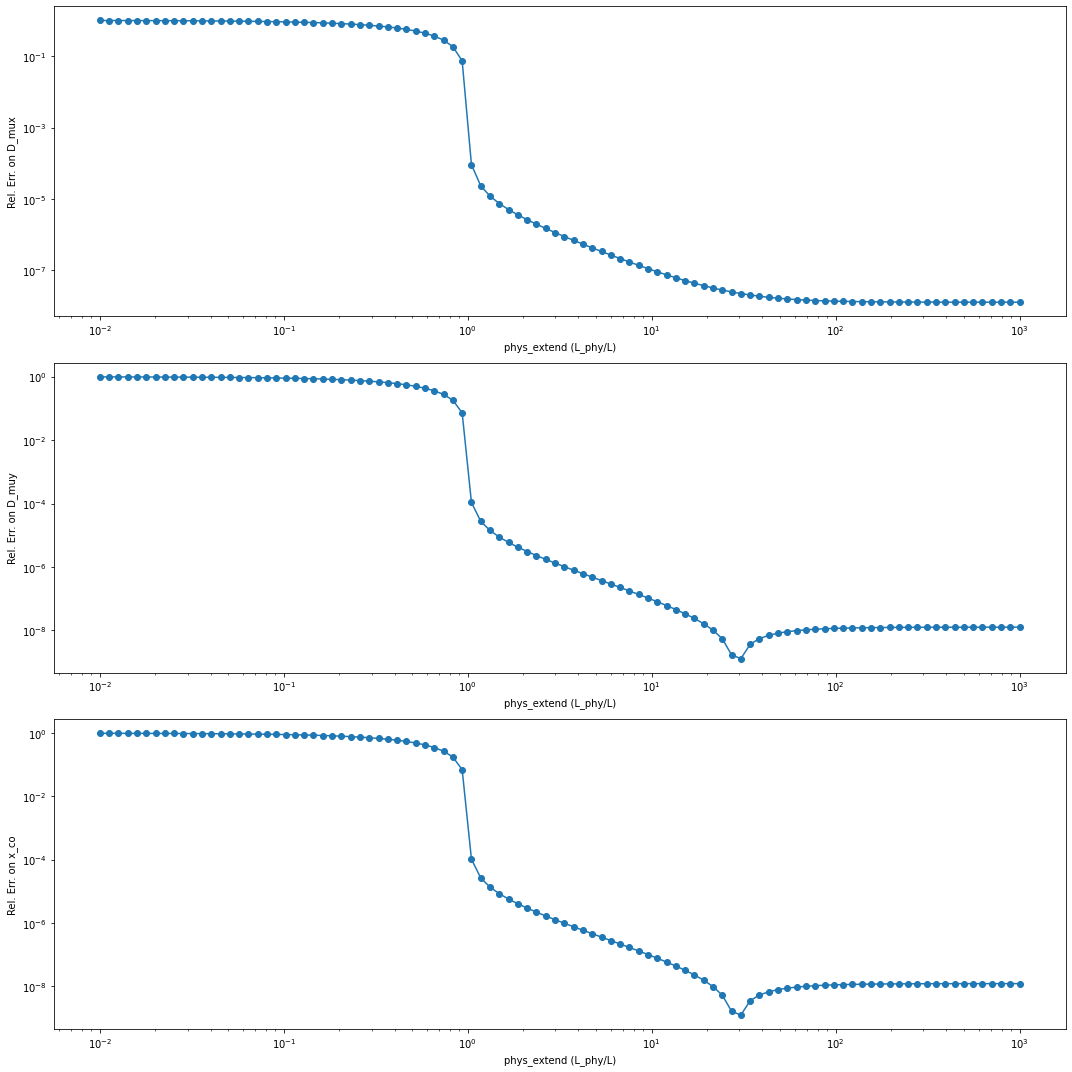

In [4]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from cpymad.madx import Madx




# Running mad file
mad = Madx(command_log = 'convergence_log.mad')
mad.option(echo = True, warn = True)
mad.call(file='convergence.mad')

# Extracting twiss tables
twiss_ref = mad.table['twiss_ref'].dframe()
#=================================================


current = 230
sweep = {'tobias':[f'phys_extend = {value};' for value in np.logspace(-2,3,100)],
              'bb': ['phys_extend = 1;']}
results = {'Conditions':[],'Parameter':[],'Sweep':[],'D_mux':[],'D_muy':[],'x_co':[]}

#Looping
for wireLabel in ['tobias','bb']:
    
    # Powering the wire:
    mad.input('I_tobias = 0; I_bb = 0;'.replace(f'I_{wireLabel} = 0',f'I_{wireLabel} = {current}'))
    mad.input('int_window = 1;phys_extend = 1;')
    
    for parameter in sweep[wireLabel]:
        # Generating twiss
        mad.input(parameter)
        mad.input(f'twiss,table=twiss_wire_{wireLabel},file="Convergence_output/twiss_wire_{wireLabel}.tfs";')

        # Extracting twiss
        twiss = mad.table[f'twiss_wire_{wireLabel}'].dframe()
        DQx = twiss.iloc[-1]['mux'] - twiss_ref.iloc[-1]['mux']
        DQy = twiss.iloc[-1]['muy'] - twiss_ref.iloc[-1]['muy']

        
        # Saving
        results['Conditions'].append((wireLabel,current))
        results['Parameter'].append(parameter.split('=')[0])
        results['Sweep'].append(float(parameter.split('=')[1][:-1]))
        results['D_mux'].append(DQx)
        results['D_muy'].append(DQy)
        results['x_co'].append(np.max(twiss["x"]))
        
results = pd.DataFrame(results)
results.set_index('Conditions',inplace=True)
display(results)   

fig,axes = plt.subplots(3,1,figsize=(15,15))

bb_results = results.groupby('Conditions').get_group(('bb',current)).copy()
tobias_results = results.groupby('Conditions').get_group(('tobias',current)).copy()

for ax,observable in zip(axes,['D_mux','D_muy','x_co']):
    plt.sca(ax)
    bb_ref = bb_results.iloc[0][observable]
    obs = np.array(tobias_results[observable])
    sweep = np.array(tobias_results['Sweep'])
    plt.plot(sweep,np.abs(obs-bb_ref)/np.abs(bb_ref),'-o')
    plt.xlabel(tobias_results['Parameter'][0]+ '(L_phy/L)')
    plt.ylabel('Rel. Err. on ' + observable)
    plt.xscale('log')
    plt.yscale('log')
    
plt.tight_layout()
plt.savefig('Convergence_output/phys_extend.png',format='png',dpi=300)

# Testing drift length (L != 0)

In [5]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from cpymad.madx import Madx




# Running mad file
mad = Madx(command_log = 'driftTest_log.mad')
mad.option(echo = True, warn = True)
mad.call(file='driftTest.mad')

# Extracting twiss tables
twiss_ref = mad.table['twiss_ref'].dframe()
#=================================================



mad.input('I_tobias = 0;L_mad = 1;L_drift = 0;')
mad.input('use, sequence = FODO_wire; ')
mad.input(f'twiss,table=twiss_wire,file="twiss_wire.tfs"')
twiss_wire = mad.table[f'twiss_wire'].dframe()
          
          
mad.input('I_tobias = 0;L_mad = 0;L_drift = 1;')
mad.input('use, sequence = FODO_drift; ')
mad.input(f'twiss,table=twiss_drift,file="twiss_drift.tfs"')
twiss_drift = mad.table[f'twiss_drift'].dframe()


# Making sure the two are equivalent.
twiss_wire.reset_index().drop(columns=['index','name','keyword']) == twiss_drift.reset_index().drop(columns=['index','name','keyword'])


s  betx  alfx   mux  bety  alfy   muy     x    px     y  ...  sig54  \
0  True  True  True  True  True  True  True  True  True  True  ...   True   
1  True  True  True  True  True  True  True  True  True  True  ...   True   
2  True  True  True  True  True  True  True  True  True  True  ...   True   
3  True  True  True  True  True  True  True  True  True  True  ...   True   
4  True  True  True  True  True  True  True  True  True  True  ...   True   
5  True  True  True  True  True  True  True  True  True  True  ...   True   
6  True  True  True  True  True  True  True  True  True  True  ...   True   
7  True  True  True  True  True  True  True  True  True  True  ...   True   
8  True  True  True  True  True  True  True  True  True  True  ...   True   

   sig55  sig56  sig61  sig62  sig63  sig64  sig65  sig66    n1  
0   True   True   True   True   True   True   True   True  True  
1   True   True   True   True   True   True   True   True  True  
2   True   True   True   True   True   True   True   True  True  
3   True   True   True   True   True   True   True   True  True  
4   True   True   True   True   True   True   True   True  True  
5   True   True   True   True   True   True   True   True  True  
6   True   True   True   True   True   True   True   True  True  
7   True   True   True   True   True   True   True   True  True  
8   True   True   True   True   True   True   True   True  True  

[9 rows x 254 columns]

# Location of wire in embeded drift?

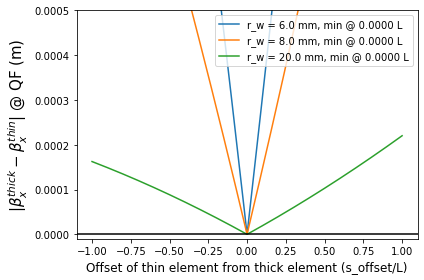

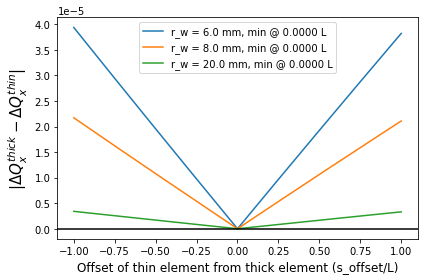

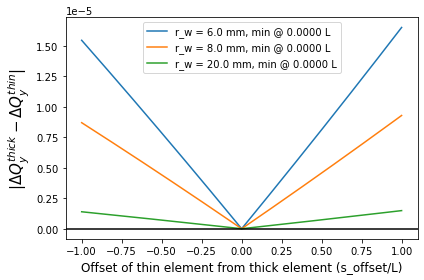

In [6]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from cpymad.madx import Madx




# Running mad file
mad = Madx(command_log = 'driftTest_log.mad')
mad.option(echo = True, warn = True)
mad.call(file='driftTest.mad')

# Extracting twiss tables
twiss_ref = mad.table['twiss_ref'].dframe()
#=================================================





L_mad = 2
plt.figure('betx')
plt.figure('DQx')
plt.figure('DQy')
for r_w in [6e-3,8e-3,20e-3]:
    mad.input(f'r_w = {r_w};')
    mad.input(f'I_tobias = 230;L_mad = {L_mad};L_drift = 0;s_offset = 0;')
    mad.input('use, sequence = FODO_wire; ')
    mad.input(f'twiss,table=twiss_wire,file="twiss_wire.tfs"')
    twiss_wire = mad.table[f'twiss_wire'].dframe()

    # betx
    ref_QF_betx = twiss_wire.loc['q2']['betx']
    cmp_QF_betx = []
    
    # Tune shift
    ref_DQx =  twiss_wire.iloc[-1]['mux'] - twiss_ref.iloc[-1]['mux']
    ref_DQy =  twiss_wire.iloc[-1]['muy'] - twiss_ref.iloc[-1]['muy']
    
    cmp_DQx = []
    cmp_DQy = []
    
    
    s_offset_array = np.linspace(-L_mad,L_mad,201)
    for s_offset in s_offset_array:
        mad.input(f'I_tobias = 230;L_mad = 0;L_drift = 0;s_offset = {s_offset};')
        mad.input('use, sequence = FODO_wire; ')
        mad.input(f'twiss,table=twiss_offset,file="twiss_offset.tfs"')
        twiss_wire_offset = mad.table[f'twiss_offset'].dframe()
        
        #saving
        cmp_QF_betx.append(twiss_wire_offset.loc['q2']['betx'])
        cmp_DQx.append(twiss_wire_offset.iloc[-1]['mux'] - twiss_ref.iloc[-1]['mux'])
        cmp_DQy.append(twiss_wire_offset.iloc[-1]['muy'] - twiss_ref.iloc[-1]['muy'])

    
    plt.figure('betx')
    delta = np.abs(np.array(cmp_QF_betx)-ref_QF_betx)
    plt.plot((s_offset_array)/L_mad,delta,'-',label=f'r_w = {r_w/1e-3} mm, min @ {(s_offset_array[np.argmin(delta)])/L_mad:.4f} L')

    plt.figure('DQx')
    delta = np.abs(np.array(cmp_DQx)-ref_DQx)
    plt.plot((s_offset_array)/L_mad,delta,'-',label=f'r_w = {r_w/1e-3} mm, min @ {(s_offset_array[np.argmin(delta)])/L_mad:.4f} L')

    
    plt.figure('DQy')
    delta = np.abs(np.array(cmp_DQy)-ref_DQy)
    plt.plot((s_offset_array)/L_mad,delta,'-',label=f'r_w = {r_w/1e-3} mm, min @ {(s_offset_array[np.argmin(delta)])/L_mad:.4f} L')

plt.figure('betx')  
plt.axhline(0,color='k')
plt.ylim([-0.00001,0.0005])
plt.ylabel(r'$|\beta_x^{thick} - \beta_x^{thin}|$ @ QF (m)',fontsize=15)
plt.xlabel(r'Offset of thin element from thick element (s_offset/L)',fontsize=12)
plt.legend()
plt.tight_layout()
plt.savefig('Convergence_output/s_offset_betx.png',format='png',dpi=300)

plt.figure('DQx')  
plt.axhline(0,color='k')
#plt.ylim([-0.00001,0.0005])
plt.ylabel(r'$|\Delta Q_x^{thick} - \Delta Q_x^{thin}|$',fontsize=15)
plt.xlabel(r'Offset of thin element from thick element (s_offset/L)',fontsize=12)
plt.legend()
plt.tight_layout()
plt.savefig('Convergence_output/s_offset_DQx.png',format='png',dpi=300)

plt.figure('DQy')  
plt.axhline(0,color='k')
#plt.ylim([-0.00001,0.0005])
plt.ylabel(r'$|\Delta Q_y^{thick} - \Delta Q_y^{thin}|$',fontsize=15)
plt.xlabel(r'Offset of thin element from thick element (s_offset/L)',fontsize=12)
plt.legend()
plt.tight_layout()
plt.savefig('Convergence_output/s_offset_DQy.png',format='png',dpi=300)

# Multi-wire configuration

```
label: WIRE, CURRENT={real, ...}, L=real,
             L_INT={real, ...}, L_PHY={real, ...},
             XMA={real,...}, ..., YMA={real, ...};
```

The `WIRE` element allows defining one or several `WIRE` elements at once. 
- `L` The length of the element in the sequence.
- `CURRENT` The current for the wires in Amperes . 
- `L_PHY` This should correspond to the actual physical length of the wires. 
- `L_INT` The length where we stop integrating the effect of the field. It needs to be larger or the same as `L_PHY`.
- `XMA` This specifies the horizontal offset of the wire compared to the reference orbit. 
- `YMA` This specifies the vertical offset of the wire compared to the reference orbit. 


The `WIRE` as implemented in MAD-X is imlemented as a thin kick. However, it is still 
possible to define a length of the wire but internally the element is 
placed in the middle and drift spaces are placed on each side of the `WIRE`.
Note also that the collimator element has the same attiributes as the `WIRE`
and by defining it using the same parameters you can also get the collimator with a wire
inside. 


In [10]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from cpymad.madx import Madx


# Running mad file
mad = Madx()
mad.option(echo = True, warn = True)
mad.call(file='multiwire.mad')

# Extracting twiss tables
twiss_ref = mad.table['twiss_ref'].dframe()
tableNames = list(mad.table.keys())[2:]




fig,axes = plt.subplots(len(tableNames),1,figsize=(15,15))
for table,ax in zip(tableNames,axes):
    twiss = mad.table[table].dframe()
    
    DQx = twiss.iloc[-1]['mux'] - twiss_ref.iloc[-1]['mux']
    DQy = twiss.iloc[-1]['muy'] - twiss_ref.iloc[-1]['muy']
    

    plt.sca(ax)
    plt.axhline(0,color='k')
    plt.plot(twiss['s'],twiss['x']/1e-3,'--o',color='C1',linewidth=2,label=r'$x_\mathrm{co}$, '+rf'$\Delta Q_x = {DQx:.3e}$')
    plt.plot(twiss['s'],twiss['y']/1e-3,'--o',color='C2',linewidth=2,label=r'$y_\mathrm{co}$, '+rf'$\Delta Q_y = {DQy:.3e}$')
    
    
    plt.ylim([-0.05,0.05])
    plt.xlabel(r'$s$ (m)',fontsize=15)
    plt.ylabel(r'Closed Orbit (mm)',fontsize=15)

    leg = plt.legend(title = 'table: ' + table, fontsize=15)
    plt.setp(leg.get_title(),fontsize=16)
    
plt.tight_layout()

In [65]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from cpymad.madx import Madx


# Running mad file
mad = Madx()
mad.option(echo = True, warn = True)
mad.call(file='multiwire.mad')

# Extracting twiss tables
twiss_ref = mad.table['twiss_ref'].dframe()

# Definining looping parameters
currentsKnob = 'I_w1 = 0;I_m1 = 0;I_w2 = 0;I_m2 = 0;'
toChange = ['I_w1','I_m1']
I_array = np.linspace(100,300,50)

results_DQx = {key:[] for key in toChange}
results_DQy = {key:[] for key in toChange}



for label in toChange:
    # Initialize currents at 0
    mad.input(currentsKnob)
    test = []
    # Loop through current values
    for I in I_array:
        #set current value
        mad.input(currentsKnob.replace(f'{label} = 0',f'{label} = {I}'))
        mad.input('use, sequence = FODO; ')
        mad.input(f'twiss,table=twiss_sweep,file="twiss_sweep.tfs"')
        twiss = mad.table[f'twiss_sweep'].dframe()

        DQx = twiss.iloc[-1]['mux'] - twiss_ref.iloc[-1]['mux']
        DQy = twiss.iloc[-1]['muy'] - twiss_ref.iloc[-1]['muy']
    
        #Saving
        results_DQx[label].append(DQx)
        results_DQy[label].append(DQy)
        
        

fig,axes = plt.subplots(len(tableNames),1,figsize=(15,15))
for results,label,ax in zip([results_DQx,results_DQy],[r'$\Delta Q_x$',r'$\Delta Q_y$'],axes):


    plt.sca(ax)
    for key,mark in zip(results.keys(),['-o','.']):
        plt.plot(I_array,results[key],mark,alpha=0.8,label=key)
    
    
    plt.xlabel(r'Current (A)',fontsize=15)
    plt.ylabel(label,fontsize=15)
    plt.legend()
    #leg = plt.legend(title = 'table: ' + table, fontsize=15)
    #plt.setp(leg.get_title(),fontsize=16)
    
plt.tight_layout()



In [36]:

len(test)

50